# How US Presidents Died According to Wikidata


Wikidata is a free linked database that serves as a central storage for the structured data in Wikipedia and other Wikimedia projects. Yesterday, the project announced on Twitter that their [query service](https://query.wikidata.org/) is officially live.

<blockquote class="twitter-tweet" lang="en"><p lang="en" dir="ltr">The Wikidata Query service is now officially live and in production! <a href="https://t.co/D5bypZ8ZmS">https://t.co/D5bypZ8ZmS</a></p>&mdash; Wikidata (@wikidata) <a href="https://twitter.com/wikidata/status/641150926036836352">September 8, 2015</a></blockquote>

This service allows you to execute [SPARQL](https://en.wikipedia.org/wiki/SPARQL) queries for answering questions like *Whose birthday is today?* or the more morbid *How US presidents died?* I address the latter question in this notebook and show how you can query the service and process the response in Python. For more query examples see [this page](https://www.mediawiki.org/wiki/Wikibase/Indexing/SPARQL_Query_Examples).


## Setup

Load the necessary libraries, set the styling and some meta information for the chart.

In [1]:
%load_ext signature
%matplotlib inline

import requests
import helpers

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ramiro')
chartinfo = 'Author: Ramiro Gómez - ramiro.org • Data: Wikidata - wikidata.org'
infosize = 12

## Define the SPARQL query

SPARQL is a declarative language to query RDF stores. I don't have much experience with SPARQL myself, but I'll try to explain the query you see below. First we define prefixes, which serve as shortcuts to resolve resources. The names following the `SELECT` keyword are variables, which are indicated by a `?` prefix.

What these variables mean is defined by the triple patterns that follow in the `WHERE` clause. The first triple basically says that `?pid` stands for the Wikidata entity [Q11696](https://www.wikidata.org/wiki/Q11696), i. e. "President of the United States of America". The following triples define `?cid`, `?dob` and `?dod` as properties [cause of death (P509)](https://www.wikidata.org/wiki/Property:P509), [date of birth (P569)](https://www.wikidata.org/wiki/Property:P569), and [date of birth (P570)](https://www.wikidata.org/wiki/Property:P570) of a president ID respectively.

The following 2 optional patterns assign English language labels to the variables `?president` and `?cause`. By making them optional we make sure to get a result triple, even if the label is not defined in English, in which case the label value would be empty.

As said I'm by no means a SPARQL expert, so if you can improve my explanation feel to edit the [notebook on GitHub](https://github.com/yaph/ipython-notebooks/blob/master/us-presidents-causes-of-death.ipynb) and submit a pull-request.

In [2]:
query = '''PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?president ?cause ?dob ?dod WHERE {
    ?pid wdt:P39 wd:Q11696 .
    ?pid wdt:P509 ?cid .
    ?pid wdt:P569 ?dob .
    ?pid wdt:P570 ?dod .
  
    OPTIONAL {
        ?pid rdfs:label ?president filter (lang(?president) = "en") .
    }
    OPTIONAL {
        ?cid rdfs:label ?cause filter (lang(?cause) = "en") .
    }
}'''

## Get and process the data

Next we send an HTTP request to the SPARQL endpoint providing the query as a URL parameter, we also specify that we want the result encoded as JSON rather than the default XML. Thanks to the [requests library](http://docs.python-requests.org/en/latest/) this is practically self-explaining code.

In [3]:
url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
data = requests.get(url, params={'query': query, 'format': 'json'}).json()

Now we iterate through the result, creating a list of dictionaries, each of which contains values for the query variables defined above. Then we create a [Pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) from this list, print its length and the first few rows.

In [4]:
presidents = []
for item in data['results']['bindings']:
    presidents.append({
        'name': item['president']['value'],
        'cause of death': item['cause']['value'],
        'date of birth': item['dob']['value'],
        'date of death': item['dod']['value']})

df = pd.DataFrame(presidents)
print(len(df))
df.head()

47


,cause of death,date of birth,date of death,name
0,cholera,1795-11-02T00:00:00Z,1849-06-15T00:00:00Z,James K. Polk
1,heart attack,1872-07-04T00:00:00Z,1933-01-05T00:00:00Z,Calvin Coolidge
2,heart attack,1822-10-04T00:00:00Z,1893-01-17T00:00:00Z,Rutherford B. Hayes
3,heart attack,1865-11-02T00:00:00Z,1923-08-02T00:00:00Z,Warren G. Harding
4,heart attack,1837-03-18T00:00:00Z,1908-06-24T00:00:00Z,Grover Cleveland


Let's also see the data types of the columns.

In [5]:
df.dtypes

cause of death    object
date of birth     object
date of death     object
name              object
dtype: object

We have 47 records in the dataset, but [Barack Obama](https://en.wikipedia.org/wiki/Barack_Obama) is US president number 44 and some former presidents are still alive, so there must be more than one record for some presidents. To learn why this number is higher we'll sort the DataFrame by `date of birth` and `date of death`. To do so we convert the corresponding column values to datetime objects and then perform the sort operation and print out the complete result.

In [6]:
df['date of birth'] = pd.to_datetime(df['date of birth'])
df['date of death'] = pd.to_datetime(df['date of death'])
df.sort(['date of birth', 'date of death'])

,cause of death,date of birth,date of death,name
33,acute laryngitis,1732-07-04,1799-12-14,George Washington
35,bloodletting,1732-07-04,1799-12-14,George Washington
20,diarrhea,1743-04-02,1826-07-04,Thomas Jefferson
30,uremia,1743-04-02,1826-07-04,Thomas Jefferson
36,bacteremia,1743-04-02,1826-07-04,Thomas Jefferson
21,diarrhea,1743-04-13,1826-07-04,Thomas Jefferson
31,uremia,1743-04-13,1826-07-04,Thomas Jefferson
37,bacteremia,1743-04-13,1826-07-04,Thomas Jefferson
19,tuberculosis,1767-03-15,1845-06-08,Andrew Jackson
28,sepsis,1773-02-09,1841-04-04,William Henry Harrison


For several presidents there are multiple causes of death listed, apparently in some cases it is not possible to determine a single cause of death with certainty. James A. Garfield for example was shot by Charles Guiteau, but did not immediately die and consequently developed several health issues and even starvation may have played a role, see the corresponding [Wikipedia article section](https://en.wikipedia.org/wiki/James_A._Garfield#Assassination) for more details.

There are 6 records for [Thomas Jefferson](https://en.wikipedia.org/wiki/Thomas_Jefferson). The exact cause of his death also [has never been conclusively determined](http://www.monticello.org/site/research-and-collections/jeffersons-cause-death). Moreover, his date of birth is given in both [Old Style and New Style dates](https://en.wikipedia.org/wiki/Old_Style_and_New_Style_dates). While it is not appropriate to just decide for a single cause of death we can filter out these 3 dispensable records with the following statement.

In [7]:
df = df[df['date of birth'] != '1743-04-02']

## Ranking the causes of death

Finally, let's create a simple bar chart that ranks the causes of death of US presidents adding a note at the bottom so it is clear why there is no 1-to-1 correspondence of causes of death and past US presidents who died.

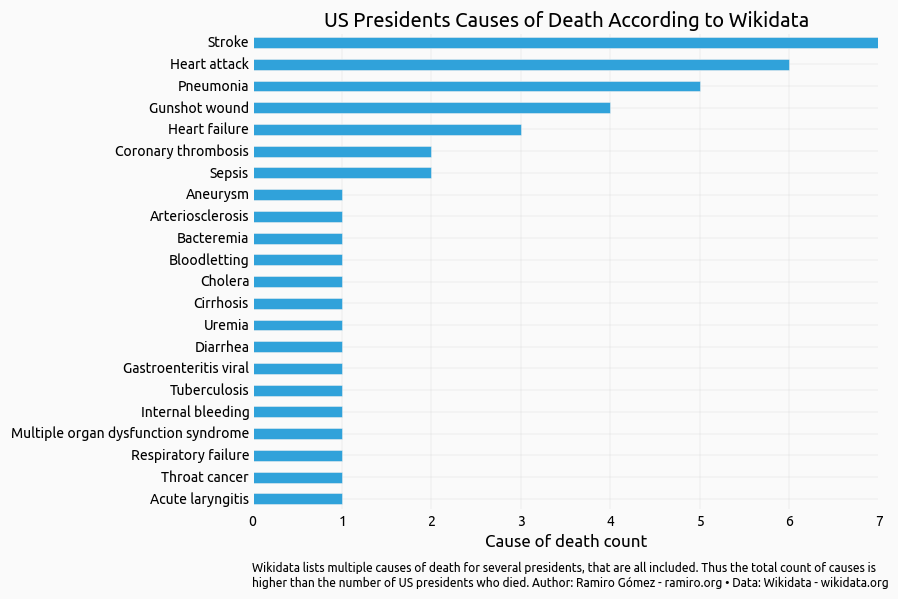

In [8]:
title = 'US Presidents Causes of Death According to Wikidata'
footer = '''Wikidata lists multiple causes of death for several presidents, that are all included. Thus the total count of causes is
higher than the number of US presidents who died. ''' + chartinfo

df['cause of death'] = df['cause of death'].apply(lambda x: x.capitalize())
s = df.groupby('cause of death').agg('count')['name'].order()

ax = s.plot(kind='barh', figsize=(10, 8), title=title)
ax.yaxis.set_label_text('')
ax.xaxis.set_label_text('Cause of death count')

ax.annotate(footer, xy=(0, -1.16), xycoords='axes fraction', fontsize=infosize)
plt.savefig('img/' + helpers.slug(title), bbox_inches='tight')

## Summary

This notebook showed a simple example of how you can query the Wikidata query service from Python. Moreover, we saw that even a very small dataset cannot just be taken for granted, but may need to be cleaned and require further research to meaningfully interpret the results.

In [9]:
%signature